#  pySUMMA Example 1 

 __This notebook implements a test of three different model representations of stomatal resistance as described in Clark et al., (2015). As seen in figure 7 of this paper, user can compare the result with this example that describe the impact of the choice stomatal resistance parameterizations on simulations of total evapotranspiration at the aspen site in Reynolds Mountain East for the intensive study period in the 2007 growing season (from 1 June to 20 August).__

## The procedure of this pySUMMA Example 1

  (1) The location of research area

  (2) Making simulation object and set simulation time
 
  (3) Assign stomatal resistance options & run SUMMA 

  (4) Show SUMMA output with Plot 

## (1) The location of research area

#### (1-1) Location : The Raynolds Mountain East catchment in southwestern Idaho
  - latitude : 43.2,      longitude : 243.2

In [1]:
from pysumma.spatial import spatial
import geopandas as gp
from jupyterthemes import jtplot
import pandas as pd
jtplot.figsize(x=10, y=10)

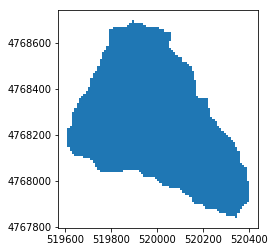

In [2]:
gdf = gp.GeoDataFrame.from_file('/home/hydro/Downloads/shape/ReynoldsMountainEast.shp')
gdf.plot()

## (2) Making simulation object and set simulation time

#### (2-1) import Simulation Module

In [3]:
%matplotlib inline
from pysumma.Simulation import Simulation

#### (2-2) Create S attribute to manipulate FileManger and Decision file

In [4]:
S = Simulation('/home/hydro/Downloads/summaTestCases_2.x/settings/wrrPaperTestCases/figure07/summa_fileManager_riparianAspenSimpleResistance.txt')

#### (2-3) get default value of simulation start date and time  in Decision text file

In [5]:
S.decision_obj.simulStart.value

'2006-07-01 00:00'

#### (2-4) set value of simulation start and finish date and time in Decision text file

In [9]:
S.decision_obj.simulStart.value = "2007-07-01 00:00"
S.decision_obj.simulFinsh.value = "2007-08-20 00:00"

#### (2-5) get available options for (06) choice of function for stomatal resistance

In [10]:
S.decision_obj.stomResist.options

['BallBerry', 'Jarvis', 'simpleResistance']

## (3) Assign stomatal resistance options & run SUMMA

### 1. Ball-Berry method
 
   https://github.com/DavidChoi76/pysumma/blob/master/BallBerry.png
   
   ![](BallBerry.png)

### 2. Jarvis method
    
   https://github.com/DavidChoi76/pysumma/blob/master/Jarvis.png
   ![](Jarvis.png)

### 3. simple soil resistance method

https://github.com/DavidChoi76/pysumma/blob/master/simple1.png
   ![](simple.png)    

<span style="color:blue"> __Above Stomal Resistance method from The structure for unifying multiple modeling alternatives (SUMMA), Version 1.0: Technical Description (April, 2005)__

#### (3-1) import widget package

In [11]:
import ipywidgets as widgets
from IPython.display import display

#### (3-2) get default value of default stomatal resistance option

In [34]:
S.decision_obj.stomResist.value

'simpleResistance'

#### (3-3) Select Ball Berry method

In [13]:
storm_resist_BallBerry = S.decision_obj.stomResist
w = widgets.Dropdown(
    options = storm_resist_BallBerry.options,
    description = storm_resist_BallBerry.name,
    disabled = False)
display(w)

Dropdown(description='stomResist', options=('BallBerry', 'Jarvis', 'simpleResistance'), value='BallBerry')

#### (3-4) Assign Ball Berry method

In [14]:
S.decision_obj.stomResist.value = w.value

#### (3-5) create S.executable attribute, run summa model and  get output of Ball Berry method

In [15]:
S.executable = "/home/hydro/Downloads/summa-master/bin/summa.exe"
results_BallBerry = S.execute("BallBerry")

#### (3-6) Select Jarvis method

In [16]:
storm_resist_Jarvis = S.decision_obj.stomResist
w = widgets.Dropdown(
    options = storm_resist_Jarvis.options,
    description = storm_resist_Jarvis.name,
    disabled = False)
display(w)

Dropdown(description='stomResist', options=('BallBerry', 'Jarvis', 'simpleResistance'), value='BallBerry')

#### (3-7) Assign Jarvis method

In [17]:
S.decision_obj.stomResist.value = w.value

#### (3-8) Run summa model and get output of Jarvis method

In [18]:
results_Jarvis = S.execute("Jarvis")

#### (3-9) Select simple soil resistance method

In [19]:
storm_resist_simResist = S.decision_obj.stomResist
w = widgets.Dropdown(
    options = storm_resist_simResist.options,
    description = storm_resist_simResist.name,
    disabled = False)
display(w)

Dropdown(description='stomResist', options=('BallBerry', 'Jarvis', 'simpleResistance'), value='BallBerry')

#### (3-10) Assign simple soil resistance method

In [33]:
S.decision_obj.stomResist.value = w.value

#### (3-11) Run summa model and get output of simple soil resistance method

In [35]:
results_simpleResistance = S.execute("simpleResistance")

## (4) Show SUMMA output with Plot

In [36]:
from pysumma.Plotting import Plotting
import matplotlib.pyplot as plt
jtplot.figsize(x=10, y=10)

#### (4-1) Get hour of day output of BallBerry method from  1 June to 20 August

In [37]:
BallBerry = (results_BallBerry['scalarCanopyTranspiration'] + results_BallBerry['scalarCanopyEvaporation'] + results_BallBerry['scalarGroundEvaporation'])*3600
dates = BallBerry.coords['time'].data
data_values = BallBerry.data
df = pd.DataFrame(data_values, index=dates)
df.index = df.index.round("H")
df_filt = df.loc["2007-06-01":"2007-08-20"]
df_filt_hour = df_filt.resample("H").mean()
BallBerry_hour = df_filt_hour.groupby(df_filt_hour.index.hour).mean()

#### (4-2) Get hour of day output of Jarvis method from  1 June to 20 August

In [38]:
Jarvis = (results_Jarvis['scalarCanopyTranspiration'] + results_Jarvis['scalarCanopyEvaporation'] + results_Jarvis['scalarGroundEvaporation'])*3600
dates = Jarvis.coords['time'].data
data_values = Jarvis.data
df = pd.DataFrame(data_values, index=dates)
df.index = df.index.round("H")
df_filt = df.loc["2007-06-01":"2007-08-20"]
df_filt_hour = df_filt.resample("H").mean()
Jarvis_hour = df_filt_hour.groupby(df_filt_hour.index.hour).mean()

#### (4-3) Get hour of day output of simple soil resistance method from  1 June to 20 August

In [39]:
simResist = (results_simpleResistance['scalarCanopyTranspiration'] + results_simpleResistance['scalarCanopyEvaporation'] + results_simpleResistance['scalarGroundEvaporation'])*3600
dates = simResist.coords['time'].data
data_values = simResist.data
df = pd.DataFrame(data_values, index=dates)
df.index = df.index.round("H")
df_filt = df.loc["2007-06-01":"2007-08-20"]
df_filt_hour = df_filt.resample("H").mean()
simResis_hour = df_filt_hour.groupby(df_filt_hour.index.hour).mean()

#### (4-4) Combine each options and add labels

In [40]:
ET_Combine = pd.concat([BallBerry_hour, Jarvis_hour,simResis_hour], axis=1)
ET_Combine.columns = ['Ball-Berry', 'Jarvis', 'Simple resistance']

#### (4-5) Result Table of three stomatal resistance methods

In [41]:
ET_Combine

,Ball-Berry,Jarvis,Simple resistance
0,-0.015287,-0.011658,-0.035278
1,-0.014787,-0.011367,-0.035717
2,-0.013658,-0.010480,-0.030926
3,-0.011582,-0.008543,-0.031286
4,-0.010706,-0.007906,-0.029081
5,-0.010698,-0.008058,-0.032018
6,-0.012603,-0.011350,-0.033209
7,-0.045649,-0.044883,-0.050479
8,-0.124121,-0.122752,-0.114845
9,-0.195222,-0.194044,-0.173953


#### (4-6) Add Obervation data in Aspen station in Reynolds Mountain East

In [42]:
Val_eddyFlux = Plotting('/home/hydro/Downloads/summaTestCases_2.x/testCases_data/validationData/ReynoldsCreek_eddyFlux.nc')
ValData_eddyFlux = Val_eddyFlux.open_netcdf()

In [43]:
Obs_Evapotranspitaton = Val_eddyFlux.ds['LE-wpl']
dates = Obs_Evapotranspitaton.coords['time'].data
data_values = Obs_Evapotranspitaton.data*0.0864*0.408/24
df = pd.DataFrame(data_values, index=dates)
df_filt = df.loc["2007-06-01":"2007-08-20"]
df_filt_hour = df_filt.resample("30T").mean()
df_filt_hour.columns = ['-','Observation (aspen)','-']
df_gp_hr = df_filt_hour.groupby([df_filt_hour.index.hour, df_filt_hour.index.minute]).mean()
df_gp_hr.reset_index(inplace=True)
xvals = df_gp_hr.reset_index()['level_0'] + df_gp_hr.reset_index()['level_1']/60.

#### (4-7) Plotting output of three options and observation data

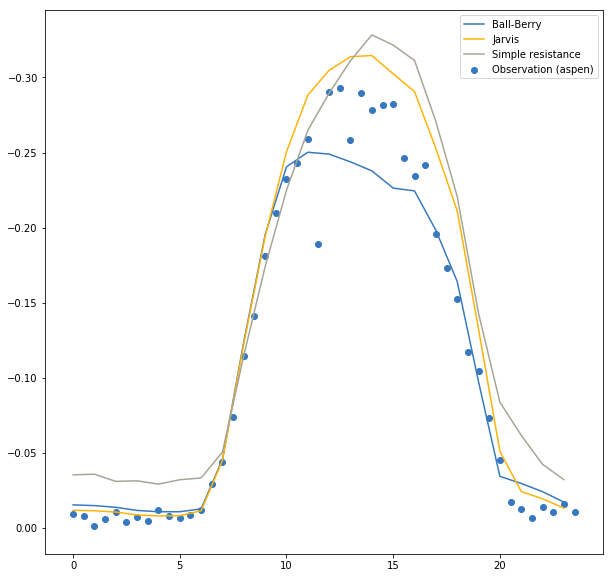

In [44]:
ET_Combine_Graph = ET_Combine.plot()
ET_Combine_Graph.invert_yaxis()
ET_Combine_Graph.scatter(xvals, df_gp_hr['Observation (aspen)'])
ET_Combine_Graph.legend()

### Description of Figure 7 (Clark et al., (2015))

* The simulations in Figure 7 illustrate substantial differences in the estimates of the diurnal cycle of transpiration depending on the choice of stomatal resistance parameterization. 
* The simple soil resistance parameterization [Liang et al., 1994], when combined with the two-source model of within-canopy and below-canopy turbulence [Choudhury and Monteith, 1988; Clark et al., 2015a], results in a substantial amount of transpiration at night when there is no light available for photosynthesis. 
* The physiological representations of transpiration – using the Jarvis and Ball-Berry parameterizations, as defined in Clark et al. [2015a] – have an explicit dependence on photosynthetically active radiation and show the expected result of zero transpiration during nighttime hours, resulting in a poor match with observations (Figure 7).
* A striking result from Figure 7 is that the Ball-Berry parameterization underestimates evapotranspiration when applied using the default model parameters for stomatal resistance in combination with the particular choice of process parameterizations and parameters for soil hydrology.